In [1]:
import tensorflow as tf
import numpy as np
import torch

import math 
import os

Init Plugin
Init Graph Optimizer
Init Kernel


In [2]:
%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt

In [3]:
import tensorflow_addons as tfa


/Users/divamgupta/miniforge3/lib/python3.9/site-packages/tensorflow_addons/utils/ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.7.0 and strictly below 2.10.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.6.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're using a tested and supported configuration, either change the TensorFlow version or the TensorFlow Addons's version. 
You can find the compatibility matrix in TensorFlow Addon's readme:
https://github.com/tensorflow/addons
  warnings.warn(


In [4]:
FILENAME = "/Users/divamgupta/Downloads/sd-v1-4.ckpt"
weights = torch.load(FILENAME)

In [5]:
def quick_gelu(x):
    return x * tf.sigmoid(x * 1.702) 


In [6]:
 
class CLIPAttention(tf.keras.layers.Layer):
    def __init__(self, tname):
        super(CLIPAttention, self).__init__()
        self.embed_dim = 768
        self.num_heads = 12
        self.head_dim = self.embed_dim // self.num_heads
        self.scale = self.head_dim**-0.5
        self.k_proj = tf.keras.layers.Dense(self.embed_dim  , activation=None , weights=[weights['state_dict'][tname+".k_proj.weight"].T  , weights['state_dict'][tname+".k_proj.bias"]] )
        self.v_proj = tf.keras.layers.Dense(self.embed_dim , activation=None  , weights=[weights['state_dict'][tname+".v_proj.weight"].T  , weights['state_dict'][tname+".v_proj.bias"]])
        self.q_proj = tf.keras.layers.Dense(self.embed_dim , activation=None  , weights=[weights['state_dict'][tname+".q_proj.weight"].T  , weights['state_dict'][tname+".q_proj.bias"]])
        self.out_proj = tf.keras.layers.Dense(self.embed_dim , activation=None  , weights=[weights['state_dict'][tname+".out_proj.weight"].T  , weights['state_dict'][tname+".out_proj.bias"]])

    def _shape(self, tensor, seq_len: int, bsz: int):
        a = tf.reshape(tensor , (bsz, seq_len, self.num_heads, self.head_dim))
        return tf.keras.layers.Permute( (2,1,3) )(a) # bs , n_head , seq_len , head_dim
    
    def call(self, inputs ):
        [hidden_states, causal_attention_mask] = inputs
        bsz, tgt_len, embed_dim = hidden_states.shape
        query_states = self.q_proj(hidden_states) * self.scale
        key_states = self._shape(self.k_proj(hidden_states), tgt_len, -1)
        value_states = self._shape(self.v_proj(hidden_states), tgt_len, -1)
        
        proj_shape = (-1 , tgt_len, self.head_dim)
        query_states = self._shape(query_states, tgt_len, -1)
        query_states = tf.reshape(query_states , proj_shape)
        key_states = tf.reshape(key_states , proj_shape)
                
        src_len = tgt_len
        value_states = tf.reshape(value_states , proj_shape)
        attn_weights = query_states @ tf.keras.layers.Permute((2,1))(key_states) 
        
        attn_weights = tf.reshape(attn_weights , (-1, self.num_heads, tgt_len, src_len))
        attn_weights = attn_weights + causal_attention_mask
        attn_weights = tf.reshape(attn_weights , (-1, tgt_len, src_len))
        
        attn_weights = tf.nn.softmax(attn_weights)
        attn_output = attn_weights @ value_states
        
        attn_output = tf.reshape(attn_output , (-1, self.num_heads, tgt_len, self.head_dim))
        attn_output = tf.keras.layers.Permute((2,1,3))(attn_output)
        attn_output = tf.reshape(attn_output , (-1, tgt_len, embed_dim))

        attn_output = self.out_proj(attn_output)
        return attn_output


In [7]:


class CLIPMLP(tf.keras.layers.Layer):
    def __init__(self, tname):
        super(CLIPMLP, self).__init__()
        self.fc1 = tf.keras.layers.Dense( 3072, weights=[weights['state_dict'][tname+".fc1.weight"].T  , weights['state_dict'][tname+".fc1.bias"]])
        self.fc2 = tf.keras.layers.Dense(  768, weights=[weights['state_dict'][tname+".fc2.weight"].T  , weights['state_dict'][tname+".fc2.bias"]])

    def __call__(self, hidden_states):
        hidden_states = self.fc1(hidden_states)
        hidden_states = quick_gelu(hidden_states )
        hidden_states = self.fc2(hidden_states)
        return hidden_states


In [8]:
class CLIPEncoderLayer(tf.keras.layers.Layer):
    def __init__(self, tname):
        super(CLIPEncoderLayer, self).__init__()
        self.self_attn = CLIPAttention(tname+".self_attn")
        self.layer_norm1 = tf.keras.layers.LayerNormalization( epsilon=1e-5 , weights=[ weights['state_dict'][tname+".layer_norm1.weight"] , weights['state_dict'][tname+".layer_norm1.bias"] ])
        self.mlp = CLIPMLP(tname+".mlp")
        self.layer_norm2 = tf.keras.layers.LayerNormalization( epsilon=1e-5 , weights=[ weights['state_dict'][tname+".layer_norm2.weight"] , weights['state_dict'][tname+".layer_norm2.bias"] ])

    def __call__(self, inputs):
        [hidden_states, causal_attention_mask] = inputs
        residual = hidden_states
    
        hidden_states = self.layer_norm1(hidden_states)
        hidden_states = self.self_attn([hidden_states, causal_attention_mask])
        hidden_states = residual + hidden_states
        
        

        residual = hidden_states
        hidden_states = self.layer_norm2(hidden_states)
        hidden_states = self.mlp(hidden_states)
        
        hidden_states = residual + hidden_states
        
        

        return hidden_states


In [9]:
class CLIPEncoder(tf.keras.layers.Layer):
    def __init__(self, tname):
        super(CLIPEncoder, self).__init__()
        self.layers = [CLIPEncoderLayer(tname + ".layers.%d"%i) for i in range(12)]
  
    def __call__(self, inputs):
        [hidden_states, causal_attention_mask] = inputs
        for i,l in enumerate(self.layers):
            hidden_states = l([hidden_states, causal_attention_mask])
        return hidden_states


In [10]:
class CLIPTextEmbeddings(tf.keras.layers.Layer):
    def __init__(self, tname , n_words=77):
        super(CLIPTextEmbeddings, self).__init__()
        
        token_emb_W = weights['state_dict'][tname + '.token_embedding.weight']


        self.token_embedding_layer = tf.keras.layers.Embedding( 49408, 768 , name="token_embedding" , weights=[token_emb_W])

        pos_emb_W = weights['state_dict'][tname + '.position_embedding.weight']


        self.position_embedding_layer = tf.keras.layers.Embedding( n_words, 768, name="position_embedding", weights=[pos_emb_W])


    def __call__(self, inputs):
        [input_ids, position_ids] = inputs
        word_embeddings = self.token_embedding_layer(input_ids)
        position_embeddings = self.position_embedding_layer(position_ids)
        return  word_embeddings + position_embeddings
          

In [11]:
class CLIPTextTransformer(tf.keras.models.Model):
    def __init__(self, tname , n_words=77):
        super(CLIPTextTransformer, self).__init__()
        self.embeddings = CLIPTextEmbeddings(tname+".embeddings" , n_words=n_words)
        self.encoder = CLIPEncoder(tname + ".encoder")
        self.final_layer_norm = tf.keras.layers.LayerNormalization( epsilon=1e-5 , weights=[ weights['state_dict'][tname+".final_layer_norm.weight"] , weights['state_dict'][tname+".final_layer_norm.bias"] ])
    
        self.inp_position_ids = tf.constant(np.array(list(range(n_words)))[None].astype('int32'))
        self.causal_attention_mask = tf.constant(np.triu(np.ones((1,1,77,77), dtype=np.float32) * -np.inf, k=1))
        
    def __call__(self, input_ids, training=False):
        x = self.embeddings([input_ids,  self.inp_position_ids ])
        x = self.encoder([x, self.causal_attention_mask] )
        return self.final_layer_norm(x)


In [12]:
def get_conv2d(tname , in_channels, out_channels, kernel_size ,padding=0 ,stride=1):
    
    W =  weights['state_dict'][tname + '.weight'].numpy()
    W = np.transpose(W , (2,3,1,0))
    assert in_channels == W.shape[-2]
    assert out_channels == W.shape[-1]
    b =  weights['state_dict'][tname + '.bias']
    
    r =  tf.keras.models.Sequential([
        
        tf.keras.layers.ZeroPadding2D(
            padding=(padding, padding), data_format=None 
        ) , 
        
        
        tf.keras.layers.Conv2D(
            out_channels,
            kernel_size,
            strides=(stride, stride ) , weights=[W,b] ) 
    ])
    return r
    

    

In [13]:
def apply_seq(x , layers):
    for l in layers:
        x = l(x)
    return x

In [14]:
# not to be confused with ResnetBlock
class ResBlock(tf.keras.layers.Layer):
  def __init__(self, tname, channels, emb_channels, out_channels):
    super(ResBlock, self).__init__()
    self.in_layers = [
      tfa.layers.GroupNormalization(epsilon=1e-5 , weights=[
        weights['state_dict'][tname+".in_layers.0.weight"],
        weights['state_dict'][tname+".in_layers.0.bias"]
      ]),
      tf.keras.activations.swish,
      get_conv2d(tname+".in_layers.2" , channels, out_channels, 3, padding=1)
    ]
    self.emb_layers = [
      tf.keras.activations.swish,
      tf.keras.layers.Dense( out_channels, weights=[weights['state_dict'][tname+".emb_layers.1.weight"].T  , weights['state_dict'][tname+".emb_layers.1.bias"]])
    ]
    self.out_layers = [
      tfa.layers.GroupNormalization(epsilon=1e-5 , weights=[
        weights['state_dict'][tname+".out_layers.0.weight"],
        weights['state_dict'][tname+".out_layers.0.bias"]
      ]),
      tf.keras.activations.swish,
      lambda x: x,
      get_conv2d(tname+".out_layers.3" ,out_channels, out_channels, 3, padding=1)
    ]
    self.skip_connection = get_conv2d(tname+".skip_connection" , channels, out_channels, 1) if channels != out_channels else lambda x: x

  def __call__(self,inputs ):
    x, emb = inputs
    h = apply_seq(x , self.in_layers)
    emb_out = apply_seq(emb, self.emb_layers)
    h = h + emb_out[:, None , None]
    h = apply_seq(h , self.out_layers)
    ret = self.skip_connection(x) + h
    return ret

In [15]:

def timestep_embedding(timesteps, dim, max_period=10000):
    half = dim // 2
    freqs = np.exp(-math.log(max_period) * np.arange(0, half, dtype=np.float32) / half)
    args = timesteps.numpy() * freqs
    embedding = np.concatenate([np.cos(args), np.sin(args)])
    return Tensor(embedding).reshape(1, -1)


In [16]:
def td_dot(a , b ):
    assert len(a.shape) == 4
    assert len(a.shape) == 4
    assert a.shape[0] == b.shape[0]
    assert b.shape[1] == a.shape[1]
    aa = tf.reshape(a , (-1 , a.shape[2] , a.shape[3]))
    bb = tf.reshape(b , (-1 , b.shape[2] , b.shape[3]))
    cc = tf.keras.backend.batch_dot(aa , bb )
    c = tf.reshape(cc , (-1 , a.shape[1] , cc.shape[1] , cc.shape[2]))
    return c 

In [17]:
class CrossAttention(tf.keras.layers.Layer):
  def __init__(self, tname, query_dim, context_dim, n_heads, d_head):
    super(CrossAttention, self).__init__()
    self.to_q = tf.keras.layers.Dense( n_heads*d_head,use_bias=False ,weights=[weights['state_dict'][tname+".to_q.weight"].T  ])
    self.to_k = tf.keras.layers.Dense( n_heads*d_head,use_bias=False ,weights=[weights['state_dict'][tname+".to_k.weight"].T  ])
    self.to_v = tf.keras.layers.Dense( n_heads*d_head,use_bias=False ,weights=[weights['state_dict'][tname+".to_v.weight"].T  ])
    self.scale = d_head ** -0.5
    self.num_heads = n_heads
    self.head_size = d_head
    self.to_out = [tf.keras.layers.Dense( n_heads*d_head ,weights=[weights['state_dict'][tname+".to_out.0.weight"].T , weights['state_dict'][tname+".to_out.0.bias"] ])]

  def __call__(self, inputs):
    assert type(inputs) is list
    if len(inputs) == 1:
        inputs = inputs + [None]
    [x , context] = inputs
    context = x if context is None else context
    q,k,v = self.to_q(x), self.to_k(context), self.to_v(context)
    assert len(x.shape) == 3
    q = tf.reshape(q , ( -1 , x.shape[1], self.num_heads, self.head_size) )
    k = tf.reshape(k , ( -1 , context.shape[1] , self.num_heads, self.head_size) )
    v = tf.reshape(v, ( -1 , context.shape[1] , self.num_heads, self.head_size) )
    
    q = tf.keras.layers.Permute((2,1,3))(q)  # (bs, num_heads, time, head_size)
    k = tf.keras.layers.Permute((2,3,1))(k)  # (bs, num_heads, head_size, time)
    v = tf.keras.layers.Permute((2,1,3))(v)# (bs, num_heads, time, head_size)
    
    score = td_dot(q,k) * self.scale
    weights = tf.keras.activations.softmax(score)                   # (bs, num_heads, time, time)
    attention = td_dot(weights,v)  
    attention = tf.keras.layers.Permute((2,1,3))(attention) # (bs, time, num_heads, head_size)

    h_ = tf.reshape(attention, (-1 ,x.shape[1] , self.num_heads * self.head_size))
    return apply_seq(h_ , self.to_out)


In [18]:

def gelu(self):
    return 0.5 * self * (1 + tf.keras.activations.tanh(self * 0.7978845608 * (1 + 0.044715 * self * self)))


In [19]:
class GEGLU(tf.keras.layers.Layer):
  def __init__(self, tname, dim_in, dim_out):
    super(GEGLU, self).__init__()
    
    self.proj = tf.keras.layers.Dense( dim_out * 2 ,weights=[weights['state_dict'][tname+".proj.weight"].T , weights['state_dict'][tname+".proj.bias"] ])
    self.dim_out = dim_out

  def __call__(self, x):
    xp = self.proj(x)
    x, gate = xp[... , :self.dim_out ] , xp[..., self.dim_out:]
    ans = x * gelu(gate)
    
    return ans


In [20]:
class FeedForward(tf.keras.layers.Layer):
  def __init__(self, tname , dim, mult=4):
    super(FeedForward, self).__init__()
    self.net = [
      GEGLU(tname + ".net.0" , dim, dim*mult),
      lambda x: x,
      tf.keras.layers.Dense( dim ,weights=[weights['state_dict'][tname+".net.2.weight"].T , weights['state_dict'][tname+".net.2.bias"] ])
    ]

  def __call__(self, x):
    return apply_seq(x, self.net)

In [21]:
class BasicTransformerBlock(tf.keras.layers.Layer):
  def __init__(self, tname, dim, context_dim, n_heads, d_head):
    super(BasicTransformerBlock, self).__init__()
    self.attn1 = CrossAttention(tname+".attn1" , dim, dim, n_heads, d_head)
    self.ff = FeedForward(tname+".ff" ,  dim)
    self.attn2 = CrossAttention(tname+".attn2" ,dim, context_dim, n_heads, d_head)
    self.norm1 = tf.keras.layers.LayerNormalization( epsilon=1e-5 , weights=[ weights['state_dict'][tname+".norm1.weight"] , weights['state_dict'][tname+".norm1.bias"] ])
    self.norm2 = tf.keras.layers.LayerNormalization( epsilon=1e-5 , weights=[ weights['state_dict'][tname+".norm2.weight"] , weights['state_dict'][tname+".norm2.bias"] ])
    self.norm3 = tf.keras.layers.LayerNormalization( epsilon=1e-5 , weights=[ weights['state_dict'][tname+".norm3.weight"] , weights['state_dict'][tname+".norm3.bias"] ])

  def __call__(self, inputs):
    [x, context] = inputs
    
    x = self.attn1([self.norm1(x)]) + x
    x = self.attn2([self.norm2(x), context]) + x
    x = self.ff(self.norm3(x)) + x
    return x

In [22]:
class SpatialTransformer(tf.keras.layers.Layer):
  def __init__(self, tname , channels, context_dim, n_heads, d_head):
    super(SpatialTransformer, self).__init__()
    self.norm = tfa.layers.GroupNormalization(epsilon=1e-5 , weights=[
        weights['state_dict'][tname+".norm.weight"],
        weights['state_dict'][tname+".norm.bias"]
      ])
    
    assert channels == n_heads * d_head
    self.proj_in = get_conv2d(tname+".proj_in", channels, n_heads * d_head, 1)
    self.transformer_blocks = [BasicTransformerBlock(tname + ".transformer_blocks.0",  channels, context_dim, n_heads, d_head)]
    self.proj_out = get_conv2d(tname+".proj_out" , n_heads * d_head, channels, 1)

  def __call__(self, inputs):
    [x , context] = inputs
    b, h, w , c  = x.shape
    x_in = x
    x = self.norm(x)
    x = self.proj_in(x)
    x = tf.reshape(x , (-1,   h*w , c) ) 
    for block in self.transformer_blocks:
      x = block([x, context])
    x = tf.reshape(x , (-1 , h, w , c) )
    ret = self.proj_out(x) + x_in
    return ret

In [23]:
class Downsample(tf.keras.layers.Layer):
  def __init__(self, tname , channels):
    super(Downsample, self).__init__()
    self.op = get_conv2d(tname + ".op" , channels, channels, 3, stride=2, padding=1)

  def __call__(self, x):
    return self.op(x)


In [24]:
class Upsample(tf.keras.layers.Layer):
  def __init__(self, tname , channels):
    super(Upsample, self).__init__()
    self.conv = get_conv2d(tname + ".conv" ,channels, channels, 3, padding=1)
    self.ups = tf.keras.layers.UpSampling2D(size=(2, 2))

  def __call__(self, x):
    x = self.ups(x)
    return self.conv(x)


In [25]:
class UNetModel(tf.keras.models.Model):
  def __init__(self, tname):
    super(UNetModel, self).__init__()
    self.time_embed = [
       tf.keras.layers.Dense( 1280, weights=[weights['state_dict'][tname+".time_embed.0.weight"].T  , weights['state_dict'][tname+".time_embed.0.bias"]]),
       tf.keras.activations.swish,
       tf.keras.layers.Dense( 1280, weights=[weights['state_dict'][tname+".time_embed.2.weight"].T  , weights['state_dict'][tname+".time_embed.2.bias"]]),
     ]

    self.input_blocks = [
      [get_conv2d( tname+".input_blocks.0.0",  4, 320, kernel_size=3, padding=1)],
      [ResBlock(tname+".input_blocks.1.0", 320, 1280, 320) ,   SpatialTransformer(tname+".input_blocks.1.1" , 320, 768, 8, 40)],
      [ResBlock(tname+".input_blocks.2.0" , 320, 1280, 320), SpatialTransformer(tname+".input_blocks.2.1" ,320, 768, 8, 40)],
      [Downsample(tname+".input_blocks.3.0" ,320)],
      [ResBlock(tname+".input_blocks.4.0",320, 1280, 640), SpatialTransformer(tname+".input_blocks.4.1" ,640, 768, 8, 80)],
      [ResBlock(tname+".input_blocks.5.0",640, 1280, 640), SpatialTransformer(tname+".input_blocks.5.1",640, 768, 8, 80)],
      [Downsample(tname+".input_blocks.6.0",640)],
      [ResBlock(tname+".input_blocks.7.0",640, 1280, 1280), SpatialTransformer(tname+".input_blocks.7.1",1280, 768, 8, 160)],
      [ResBlock(tname+".input_blocks.8.0",1280, 1280, 1280), SpatialTransformer(tname+".input_blocks.8.1",1280, 768, 8, 160)],
      [Downsample(tname+".input_blocks.9.0",1280)],
      [ResBlock(tname+".input_blocks.10.0",1280, 1280, 1280)],
      [ResBlock(tname+".input_blocks.11.0",1280, 1280, 1280)]
    ]
    self.middle_block = [
      ResBlock(tname+".middle_block.0",1280, 1280, 1280),
      SpatialTransformer(tname+".middle_block.1",1280, 768, 8, 160),
      ResBlock(tname+".middle_block.2",1280, 1280, 1280)
    ]
    self.output_blocks = [
      [ResBlock(tname+".output_blocks.0.0", 2560, 1280, 1280)],
      [ResBlock(tname+".output_blocks.1.0",2560, 1280, 1280)],
      [ResBlock(tname+".output_blocks.2.0",2560, 1280, 1280), Upsample(tname+".output_blocks.2.1",1280)],
      [ResBlock(tname+".output_blocks.3.0",2560, 1280, 1280), SpatialTransformer(tname+".output_blocks.3.1",1280, 768, 8, 160)],
      [ResBlock(tname+".output_blocks.4.0",2560, 1280, 1280), SpatialTransformer(tname+".output_blocks.4.1",1280, 768, 8, 160)],
      [ResBlock(tname+".output_blocks.5.0",1920, 1280, 1280), SpatialTransformer(tname+".output_blocks.5.1",1280, 768, 8, 160), Upsample(tname+".output_blocks.5.2",1280)],
      [ResBlock(tname+".output_blocks.6.0",1920, 1280, 640), SpatialTransformer(tname+".output_blocks.6.1",640, 768, 8, 80)],  # 6
      [ResBlock(tname+".output_blocks.7.0",1280, 1280, 640), SpatialTransformer(tname+".output_blocks.7.1",640, 768, 8, 80)],
      [ResBlock(tname+".output_blocks.8.0",960, 1280, 640), SpatialTransformer(tname+".output_blocks.8.1",640, 768, 8, 80), Upsample(tname+".output_blocks.8.2",640)],
      [ResBlock(tname+".output_blocks.9.0",960, 1280, 320), SpatialTransformer(tname+".output_blocks.9.1",320, 768, 8, 40)],
      [ResBlock(tname+".output_blocks.10.0",640, 1280, 320), SpatialTransformer(tname+".output_blocks.10.1",320, 768, 8, 40)],
      [ResBlock(tname+".output_blocks.11.0",640, 1280, 320), SpatialTransformer(tname+".output_blocks.11.1",320, 768, 8, 40)],
    ]
    self.out = [
      tfa.layers.GroupNormalization(epsilon=1e-5 , weights=[
        weights['state_dict'][tname+".out.0.weight"],
        weights['state_dict'][tname+".out.0.bias"]
      ]),
        
      tf.keras.activations.swish,
      get_conv2d(tname+".out.2", 320, 4, kernel_size=3, padding=1)
    ]

  def __call__(self, inputs, training=False):
    # TODO: real time embedding
    [x,t_emb,context] = inputs
    emb = apply_seq(t_emb, self.time_embed)

    def run(x, bb):
      if isinstance(bb, ResBlock): x = bb([x, emb])
      elif isinstance(bb, SpatialTransformer): x = bb([x, context])
      else: x = bb(x)
      return x

    saved_inputs = []
    for i,b in enumerate(self.input_blocks):
      for bb in b:
        inppp = x
        x = run(x, bb)
      saved_inputs.append(x)
    
    for bb in self.middle_block:
      x = run(x, bb)

    for i,b in enumerate(self.output_blocks):
      x = tf.concat([x , saved_inputs.pop()] , axis=-1) 
      for bb in b:
        x = run(x, bb)
    return apply_seq(x , self.out)



In [26]:
class AttnBlock(tf.keras.layers.Layer):
  def __init__(self, tname , in_channels):
    super(AttnBlock, self).__init__()
    self.norm = tfa.layers.GroupNormalization(epsilon=1e-5 , weights=[
        weights['state_dict'][tname+".norm.weight"],
        weights['state_dict'][tname+".norm.bias"]
      ])
    self.q = get_conv2d(tname+".q" , in_channels, in_channels, 1)
    self.k = get_conv2d(tname+".k" , in_channels, in_channels, 1)
    self.v = get_conv2d(tname+".v" , in_channels, in_channels, 1)
    self.proj_out = get_conv2d(tname+".proj_out" ,in_channels, in_channels, 1)

  # copied from AttnBlock in ldm repo
  def __call__(self, x):
    h_ = self.norm(x)
    q,k,v = self.q(h_), self.k(h_), self.v(h_)

    # compute attention
    b, h,w, c = q.shape
    q = tf.reshape(q , (-1 ,h*w , c ))# b,hw,c
    k = tf.keras.layers.Permute((3,1,2))(k)
    k = tf.reshape(k , (-1,c,h*w)) # b,c,hw
    w_ = q @ k
    w_ = w_ * (c**(-0.5))
    w_ = tf.keras.activations.softmax (w_)
    


    # attend to values
    v = tf.keras.layers.Permute((3,1,2))(v)
    v = tf.reshape(v , (-1,c,h*w))
    w_ = tf.keras.layers.Permute((2,1))( w_)
    h_ = v @ w_
    h_ = tf.keras.layers.Permute((2,1))(h_)
    h_ = tf.reshape(h_, (-1,h,w,c))
    return x + self.proj_out(h_)

In [27]:
class ResnetBlock(tf.keras.layers.Layer):
  def __init__(self, tname ,  in_channels, out_channels=None):
    super(ResnetBlock, self).__init__()
    self.norm1 = tfa.layers.GroupNormalization(epsilon=1e-5 , weights=[
        weights['state_dict'][tname+".norm1.weight"],
        weights['state_dict'][tname+".norm1.bias"]
      ])
    self.conv1 = get_conv2d(tname+".conv1", in_channels, out_channels, 3, padding=1)
    self.norm2 = tfa.layers.GroupNormalization(epsilon=1e-5 , weights=[
        weights['state_dict'][tname+".norm2.weight"],
        weights['state_dict'][tname+".norm2.bias"]
      ])
    self.conv2 = get_conv2d(tname+".conv2",out_channels, out_channels, 3, padding=1)
    self.nin_shortcut = get_conv2d(tname+".nin_shortcut", in_channels, out_channels, 1) if in_channels != out_channels else lambda x: x

  def __call__(self, x):
    h = self.conv1(tf.keras.activations.swish(self.norm1(x)) )
    h = self.conv2(tf.keras.activations.swish(self.norm2(h)) )
    return self.nin_shortcut(x) + h


In [28]:
class Mid(tf.keras.layers.Layer):
  def __init__(self, tname , block_in):
    super(Mid, self).__init__()
    self.block_1 = ResnetBlock(tname+".block_1" , block_in, block_in)
    self.attn_1 = AttnBlock(tname+".attn_1" ,block_in)
    self.block_2 = ResnetBlock(tname+".block_2" , block_in, block_in)

  def __call__(self, x):
    return apply_seq(x , [self.block_1, self.attn_1, self.block_2])


In [29]:
class Decoder(tf.keras.models.Model):
  def __init__(self, tname ):
    super(Decoder, self).__init__()
    sz = [(128, 256), (256, 512), (512, 512), (512, 512)]
    self.conv_in = get_conv2d( tname+".conv_in" ,  4,512,3, padding=1)
    self.mid = Mid(tname+".mid" , 512)
    self.upp = tf.keras.layers.UpSampling2D(size=(2, 2))
    
    self.post_quant_conv = get_conv2d("first_stage_model.post_quant_conv" , 4, 4, 1)

    arr = []
    for i,s in enumerate(sz):
      arr.append({"block":
        [ResnetBlock( tname + ".up.%d.block.0"%i , s[1], s[0]),
         ResnetBlock( tname + ".up.%d.block.1"%i , s[0], s[0]),
         ResnetBlock( tname + ".up.%d.block.2"%i , s[0], s[0])]})
      if i != 0: arr[-1]['upsample'] = {"conv": get_conv2d( tname + ".up.%d.upsample.conv"%i , s[0], s[0], 3, padding=1)}
    self.up = arr

    self.norm_out = tfa.layers.GroupNormalization(epsilon=1e-5 , weights=[
        weights['state_dict'][tname+".norm_out.weight"],
        weights['state_dict'][tname+".norm_out.bias"]
      ])
    self.conv_out = get_conv2d(tname+ ".conv_out" , 128, 3, 3, padding=1)

  def __call__(self, x, training=False):
    
    x = self.post_quant_conv(1/0.18215 * x)

    x = self.conv_in(x)
    x = self.mid(x)

    for l in self.up[::-1]:
      for b in l['block']: x = b(x)
      if 'upsample' in l:
        # https://pytorch.org/docs/stable/generated/torch.nn.functional.interpolate.html ?
        bs,c,py,px = x.shape
        x = self.upp(x)
        x = l['upsample']['conv'](x)

    return self.conv_out(tf.keras.activations.swish (self.norm_out(x)) )


In [30]:
# init the model


In [65]:
text_max_len = 77


def get_text_enc():
    input_word_ids = tf.keras.layers.Input( #intentinally using keas. rather than tf.keras. becasue of some stupid bug in tfhub and pyinstaller 
            shape=(text_max_len,), dtype=tf.int32)
    embeds = CLIPTextTransformer('cond_stage_model.transformer.text_model')(input_word_ids)
    return tf.keras.models.Model(input_word_ids , embeds)

def get_unet():
    context = tf.keras.layers.Input((text_max_len,768))
    t_emb = tf.keras.layers.Input((320,))
    latent = tf.keras.layers.Input((64,64,4))
    unet = UNetModel("model.diffusion_model")

    return tf.keras.models.Model([latent , t_emb, context ] , unet([latent , t_emb, context]))
    
def get_decoder():
    latent = tf.keras.layers.Input((64,64,4))
    decoder = Decoder("first_stage_model.decoder")
    return tf.keras.models.Model(latent , decoder(latent))
    


In [66]:
text_encoder = get_text_enc()
unet = get_unet()
decoder = get_decoder()

In [67]:
from transformers import CLIPTokenizer
tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-base-patch32")

In [68]:


inputs = tokenizer(["an astronaut riding a hourse"], padding=True)



In [69]:
batch_size = 1

In [81]:

phrase = inputs['input_ids'][0] + [49407]*(77-len(inputs['input_ids'][0]))

phrase = np.array(phrase)[None].astype("int32")
phrase = np.repeat(phrase , batch_size, axis=0)
phrase = tf.convert_to_tensor(phrase)
context = text_encoder(phrase)
context.shape

TensorShape([1, 77, 768])

In [82]:
phrase = [49406, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407]
phrase = np.array(phrase)[None].astype("int32")
phrase = np.repeat(phrase , batch_size, axis=0)

phrase = tf.convert_to_tensor(phrase)
unconditional_context = text_encoder(phrase)

In [83]:

def timestep_embedding(timesteps, dim=320, max_period=10000):
  half = dim // 2
  freqs = np.exp(-math.log(max_period) * np.arange(0, half, dtype=np.float32) / half)
  print(freqs.shape)
  args = np.array(timesteps) * freqs
  embedding = np.concatenate([np.cos(args), np.sin(args)])
  return (embedding).reshape(1, -1)

In [112]:
def get_model_output(latent, t):
    # put into diffuser
    timesteps = np.array([t])
    t_emb = tf.convert_to_tensor(timestep_embedding(timesteps))
    t_emb = np.repeat(t_emb , batch_size, axis=0)

    
    unconditional_latent = unet([latent, t_emb, unconditional_context])
    latent = unet([latent, t_emb, context])
    unconditional_guidance_scale = 7.5
    e_t = unconditional_latent + unconditional_guidance_scale * (latent - unconditional_latent)
    return e_t

In [113]:
TIMESTEPS = int(os.getenv("TIMESTEPS", "25"))
timesteps = list(np.arange(1, 1000, 1000//TIMESTEPS))
print(f"running for {timesteps} timesteps")

running for [1, 41, 81, 121, 161, 201, 241, 281, 321, 361, 401, 441, 481, 521, 561, 601, 641, 681, 721, 761, 801, 841, 881, 921, 961] timesteps


In [114]:
alphas_cumprod = weights['state_dict']['alphas_cumprod'].numpy()

In [115]:
alphas = [alphas_cumprod[t] for t in timesteps]
alphas_prev = [1.0] + alphas[:-1]

In [116]:
def get_x_prev_and_pred_x0(x, e_t, index):
    temperature = 1
    a_t, a_prev = alphas[index], alphas_prev[index]
    sigma_t = 0
    sqrt_one_minus_at = math.sqrt(1-a_t)
    #print(a_t, a_prev, sigma_t, sqrt_one_minus_at)

    pred_x0 = (x - sqrt_one_minus_at * e_t) / math.sqrt(a_t)

    # direction pointing to x_t
    dir_xt = math.sqrt(1. - a_prev - sigma_t**2) * e_t
    noise = sigma_t *  tf.random.normal(x.shape) * temperature

    x_prev = math.sqrt(a_prev) * pred_x0 + dir_xt #+ noise
    return x_prev, pred_x0

In [117]:
latent = tf.random.normal((batch_size,64,64,4))

In [118]:
from tqdm import tqdm

In [119]:
for index, timestep in (t:=tqdm(list(enumerate(timesteps))[::-1])):
    t.set_description("%3d %3d" % (index, timestep))
    e_t = get_model_output(latent, timestep)
    x_prev, pred_x0 = get_x_prev_and_pred_x0(latent, e_t, index)
    latent = x_prev


 24 961:   0%|                                                                              | 0/25 [00:00<?, ?it/s]

(160,)


 23 921:   4%|██▊                                                                   | 1/25 [00:11<04:42, 11.76s/it]

(160,)


 22 881:   8%|█████▌                                                                | 2/25 [00:16<02:52,  7.49s/it]

(160,)


 21 841:  12%|████████▍                                                             | 3/25 [00:20<02:12,  6.04s/it]

(160,)


 20 801:  16%|███████████▏                                                          | 4/25 [00:25<01:54,  5.44s/it]

(160,)


 19 761:  20%|██████████████                                                        | 5/25 [00:32<02:02,  6.11s/it]

(160,)


 18 721:  24%|████████████████▊                                                     | 6/25 [00:38<01:55,  6.08s/it]

(160,)


 17 681:  28%|███████████████████▌                                                  | 7/25 [00:43<01:45,  5.89s/it]

(160,)


 16 641:  32%|██████████████████████▍                                               | 8/25 [00:50<01:42,  6.05s/it]

(160,)


 15 601:  36%|█████████████████████████▏                                            | 9/25 [00:55<01:33,  5.86s/it]

(160,)


 14 561:  40%|███████████████████████████▌                                         | 10/25 [01:04<01:41,  6.79s/it]

(160,)


 13 521:  44%|██████████████████████████████▎                                      | 11/25 [01:12<01:38,  7.06s/it]

(160,)


 12 481:  48%|█████████████████████████████████                                    | 12/25 [01:17<01:22,  6.37s/it]

(160,)


 11 441:  52%|███████████████████████████████████▉                                 | 13/25 [01:21<01:10,  5.91s/it]

(160,)


 10 401:  56%|██████████████████████████████████████▋                              | 14/25 [01:27<01:02,  5.70s/it]

(160,)


  9 361:  60%|█████████████████████████████████████████▍                           | 15/25 [01:32<00:56,  5.69s/it]

(160,)


  8 321:  64%|████████████████████████████████████████████▏                        | 16/25 [01:37<00:49,  5.46s/it]

(160,)


  7 281:  68%|██████████████████████████████████████████████▉                      | 17/25 [01:45<00:48,  6.05s/it]

(160,)


  6 241:  72%|█████████████████████████████████████████████████▋                   | 18/25 [01:52<00:45,  6.47s/it]

(160,)


  5 201:  76%|████████████████████████████████████████████████████▍                | 19/25 [01:58<00:38,  6.34s/it]

(160,)


  4 161:  80%|███████████████████████████████████████████████████████▏             | 20/25 [02:03<00:29,  5.97s/it]

(160,)


  3 121:  84%|█████████████████████████████████████████████████████████▉           | 21/25 [02:08<00:22,  5.69s/it]

(160,)


  2  81:  88%|████████████████████████████████████████████████████████████▋        | 22/25 [02:13<00:16,  5.54s/it]

(160,)


  1  41:  92%|███████████████████████████████████████████████████████████████▍     | 23/25 [02:18<00:10,  5.22s/it]

(160,)


  0   1:  96%|██████████████████████████████████████████████████████████████████▏  | 24/25 [02:23<00:05,  5.29s/it]

(160,)


  0   1: 100%|█████████████████████████████████████████████████████████████████████| 25/25 [02:29<00:00,  5.97s/it]


In [120]:
decoded = decoder(latent)

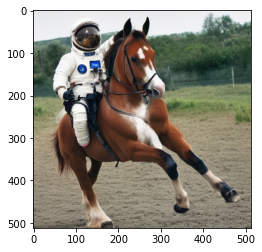

In [121]:
plt.imshow(np.clip((decoded[0].numpy()+1)/2, 0 , 1 ))

In [ ]:
plt.imshow(np.clip((decoded[1].numpy()+1)/2, 0 , 1 ))